<a href="https://colab.research.google.com/github/ChuLinh02/GraphMining/blob/main/HW05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CSC17103 - Colab 5 - Phân hoạch và phát hiện cộng đồng trên đồ thị (Tiếp theo)**

Đây là Bài tập 05 trong môn học Khai thác Dữ liệu Đồ thị (Graph Mining) - CSC1703 tại Khoa Công nghệ Thông tin, Trường Đại học Khoa học Tự nhiên, Đại học Quốc gia TP.HCM

(Cập nhật lần cuối: 21/07/2024)

Họ tên: Chu Hải Linh

MSSV: 21120496

## **Cách thực hiện và nộp bài tập**

&#9889; Chú ý, bạn nên thực hiện theo sự hướng dẫn dưới đây. Nếu có bất kỳ điều gì không rõ, bạn cần liên hệ ngay trợ giảng/ giáo viên thực hành để được hỗ trợ kịp thời.

**Cách làm bài**

Bạn sẽ làm trực tiếp trên file notebook này. Đầu tiên, bạn điền họ tên và MSSV vào phần đầu file ở bên trên. Trong file, bạn làm bài ở những chỗ có ghi là:
```python
# YOUR CODE HERE
raise NotImplementedError()
```
hoặc đối với những phần code không bắt buộc thì là:
```python
# YOUR CODE HERE (OPTION)
```
hoặc đối với markdown cell thì là:
```markdown
YOUR ANSWER HERE
```

**Cách nộp bài**

Trước khi nộp bài, bạn chọn `Kernel` - `Restart Kernel & Run All Cells` đối với trường hợp sử dụng môi trường local hoặc `Runtime` - `Restart session and run all` đối với môi trường Google Colab, để đảm bảo mọi chuyện diễn ra đúng như mong đợi.

Sau đó, bạn tạo thư mục nộp bài theo cấu trúc sau:
- Thư mục `MSSV` (ví dụ, nếu bạn có MSSV là 1234567 thì bạn đặt tên thư mục là `1234567`)
    - File `HW05.ipynb` (không cần nộp các file khác)

Cuối cùng, bạn nén thư mục `MSSV` này lại với định dạng nén là .zip (chứ không được là .rar hay các định dạng khác) và nộp ở link trên moodle. \
<font color=red>Bạn lưu ý tuân thủ chính xác qui định nộp bài này.</font>

## Setup và Import các thứ

In [1]:
# Upgrade packages
# !pip install --upgrade scipy networkx

In [2]:
# Import
import numpy as np # For numerical computation
import networkx as nx # For network/ graph manipulation
import matplotlib.pyplot as plt # For visualization
import scipy.stats as st
from scipy.stats import ks_2samp
from zlib import adler32

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

import pandas as pd
import seaborn as sns

from IPython.display import clear_output

from collections import Counter
import random

plt.style.use("fast")

from typing import List, Tuple, Dict

%matplotlib inline

In [3]:
# Make sure something
assert nx.__version__ > '2.5'

Trước khi bắt đầu, bạn copy lại hàm `eigenLaplacian` đã cài đặt trước đó nhé!

In [4]:
def eigenLaplacian(G: nx.Graph) -> Tuple[np.ndarray, np.ndarray]:
    # YOUR CODE HERE
    # Compute the Laplacian matrix
    L = nx.laplacian_matrix(G).toarray()

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(L)

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = eigenvalues.argsort()
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    return eigenvectors, eigenvalues

## Task 6. Gom cụm phổ (Spectral clustering)

Gom cụm phổ hay Spectral clustering là một thuật toán mạnh mẽ phục vụ cho tác vụ phát hiện cộng đồng mà dựa trên việc cực tiểu lát cắt đồ thị. Nó dựa trên vector riêng Laplacian, một cách nói cụ thể hơn, dấu của vector riêng nhỏ thứ hai quyết định phân hoạch đồ thị thành hai cụm.

Trong phần này, ta xem xét một dataset nhân tạo dạng đường tròn như sau:

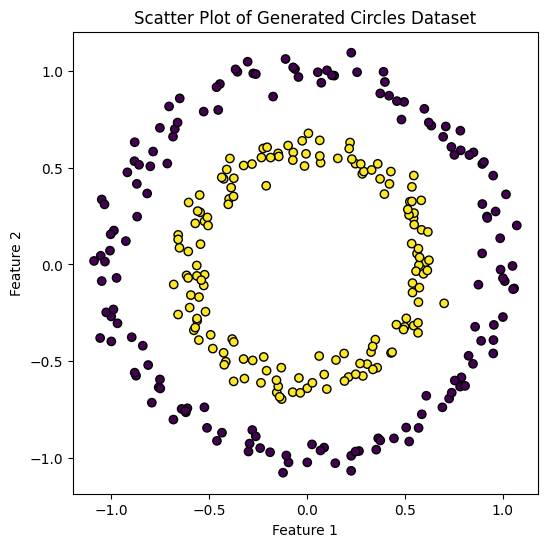

In [5]:
from sklearn import datasets

circles, truth_labels = datasets.make_circles(
    n_samples=300, factor=0.6, noise=0.05, random_state=0
)

plt.figure(figsize=(6, 6))
plt.scatter(circles[:, 0], circles[:, 1], c=truth_labels,
            cmap='viridis', edgecolor='k')
plt.title('Scatter Plot of Generated Circles Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Chúng ta hãy cô lập các điểm dữ liệu trong vòng tròn trung tâm bằng cách sử dụng gom cụm phổ. Bất kỳ tập dữ liệu dựa trên khoảng cách nào cũng có thể được biểu diễn dưới dạng đồ thị có các cạnh giữa các lân cận.

Bạn cần hoàn thành hàm `customGraph` mà nhận đầu vào là một mảng np.array với các điểm tọa độ x-y và trả về một đồ thị liên thông.

_Gợi ý: bạn thử áp dụng hàm `sklearn.neighbors.kneighbors_graph`_

_Nhận xét: bạn có thể đề xuất sử dụng khoảng cách của riêng bạn!_

In [6]:
from sklearn.neighbors import kneighbors_graph

def customGraph(data: np.ndarray) -> nx.Graph:
    # YOUR CODE HERE
    # Default number of neighbors and distance metric
    n_neighbors = 10
    metric = 'euclidean'

    # Generate the adjacency matrix using k nearest neighbors
    adjacency_matrix = kneighbors_graph(data, n_neighbors=n_neighbors,
                                        metric=metric, mode='connectivity')

    # Convert the adjacency matrix to a graph
    G = nx.Graph(adjacency_matrix)

    # Ensure the graph is connecteds by linking disconnected components
    if not nx.is_connected(G):
      # Find all connected components in the graph
      components = list(nx.connected_components(G))
      for i in range(len(components)- 1):
        # Randomly connect a node from one component to a node from the next component
        node_from_component_1 = list(components[i])[0]
        node_from_component_2 = list(components[i+1])[0]
        G.add_edge(node_from_component_1, node_from_component_2)

    return G

In [7]:
# Test
circles, truth_labels = datasets.make_circles(n_samples=300, factor=0.6,
                                              noise=0.05, random_state=0)
circlesG = customGraph(circles)
assert circlesG.number_of_nodes() == 300, "The graph should have 300 nodes"
assert nx.is_connected(circlesG), "The graph should be connected"

Trực quan hóa giá trị trong vector riêng nhỏ thứ hai của Laplacian.

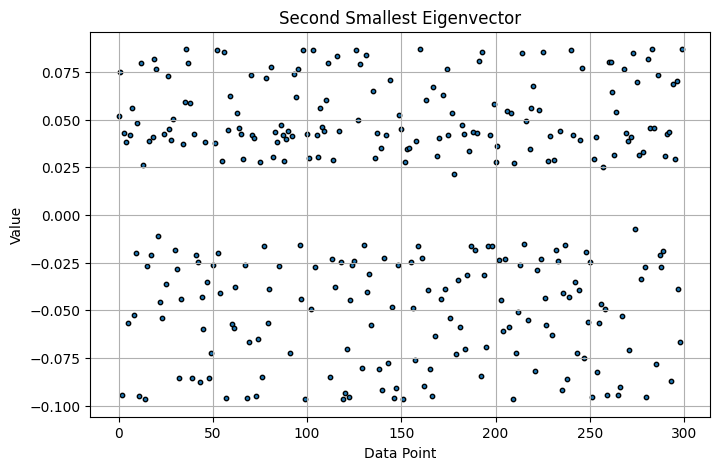

In [8]:
vecs, vals = eigenLaplacian(circlesG)

plt.figure(figsize=(8, 5))
plt.scatter(np.arange(300), vecs[:, 1], s=10, color='tab:blue', edgecolor='k')
plt.title('Second Smallest Eigenvector')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.grid(True)
plt.show()

Kế tiếp, bạn viết một hàm `spectralTwoClusters` mà nhận đầu vào là một mảng np.array vector riêng có thứ tự và trả về mảng np.array nhãn của các đỉnh.

In [9]:
def spectralTwoClusters(vecs: np.ndarray) -> np.ndarray:
    # YOUR CODE HERE
    # Extract the second smallest eigenvector (Fiedler vector)
    fiedler_vector = vecs[:, 1]

    # Determine cluster labels based on the sign of the Fiedler vector
    labels = (fiedler_vector >= 0).astype(int)

    return labels

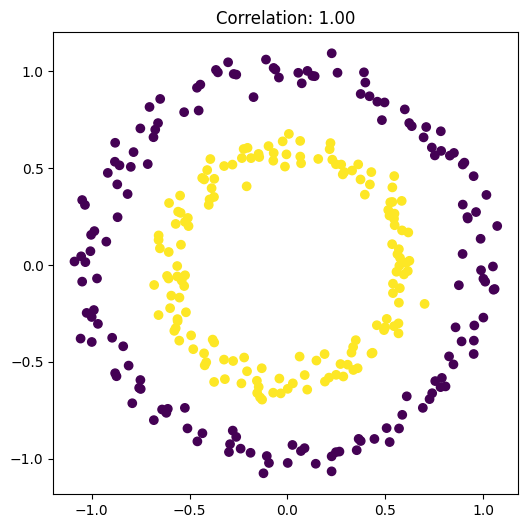

In [10]:
# Test
circles, truth_labels = datasets.make_circles(n_samples=300, factor=0.6,
                                              noise=0.05, random_state=0)
circlesG = customGraph(circles)
vecs, vals = eigenLaplacian(circlesG)
labels = spectralTwoClusters(vecs)

assert abs(np.corrcoef(truth_labels, labels)[0, 1]) > 0.95

plt.figure(figsize=(6, 6))
plt.scatter(circles[:, 0], circles[:, 1], c=labels)
plt.title('Correlation: {:.2f}'.format(abs(np.corrcoef(truth_labels, labels)[0, 1])))
plt.show()

Bạn có nhận xét gì?

YOUR ANSWER HERE

**1. Hiệu quả phân cụm**

Thuật toán đã phân chia chính xác dữ liệu thành hai cụm riêng biệt, tương ứng với các vòng tròn bên trong và bên ngoài. Điều này minh chứng rằng Spectral Clustering là một lựa chọn phù hợp để xử lý các dữ liệu phi tuyến tính và có cấu trúc hình học đặc biệt.

**2. Độ chính xác cao**

Kết quả cho thấy hệ số tương quan đạt 1.00, nghĩa là kết quả phân cụm hoàn toàn khớp với nhãn thực tế. Điều này thể hiện sự chính xác và đáng tin cậy của thuật toán trong bài toán này.

**3. Xử lý hình dạng phức tạp**

Spectral Clustering vượt trội hơn các phương pháp phân cụm truyền thống (như K-means) trong việc xử lý dữ liệu có cấu trúc hình học không gian phi tuyến tính, ví dụ như hai vòng tròn đồng tâm.

**4. Ứng dụng lý thuyết đồ thị**

Sử dụng Fiedler Vector (vector riêng thứ hai nhỏ nhất của ma trận Laplacian) để chia cụm là một bước tối ưu trong lý thuyết Spectral Clustering, cho thấy khả năng ứng dụng lý thuyết vào thực tế một cách hiệu quả.

**5. Phương pháp xây dựng đồ thị**

Việc chuyển dữ liệu điểm thành đồ thị thông qua ma trận Laplacian đã giúp thuật toán nắm bắt tốt mối quan hệ và cấu trúc dữ liệu, tạo nền tảng vững chắc để phân cụm.

_Ghi chú: ở đây có hai hướng trong xây dựng đồ thị: 1) lựa chọn các cặp đỉnh để liên kết lại với nhau, và 2) chọn trọng số trong việc khởi tạo cạnh. Hãy thử gán tham số `factor=0.7` trong `datasets.make_circles` và kiểm tra lại một lần nữa để đạt được tương quan 0.9. Kết hợp `sklearn.neighbors.kneighbors_graph` với `scipy.spatial.distance_matrix` hay `sklearn.metrics.pairwise.rbf_kernel`. Nếu bạn quan tâm, hãy đọc phân tích chi tiết [ở đây]((http://www2.imm.dtu.dk/projects/manifold/Papers/Laplacian.pdf))_

Sau khi thực hiện xong phần ghi chú, bạn để lại nhận xét của bạn ở phía dưới (phần này không tính điểm, chỉ mang tính chất điểm cộng).

In [11]:
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import rbf_kernel

def weightedGraph(data: np.ndarray, gamma: float =1.0, n_neighbors: int = 10) -> nx.Graph:
    # YOUR CODE HERE
    distances = distance_matrix(data, data)
    sorted_indices = np.argsort(distances, axis=1)
    adjacency_matrix = np.zeros_like(distances, dtype=int)

    for i in range(distances.shape[0]):
        neighbors = sorted_indices[i, 1:n_neighbors + 1]
        adjacency_matrix[i, neighbors] = 1
        adjacency_matrix[neighbors, i] = 1

    weights = rbf_kernel(data, gamma=gamma)
    weighted_adjacency_matrix = adjacency_matrix * weights

    return weighted_adjacency_matrix

def laplacian_matrix(weighted_adjacency: np.ndarray) -> np.ndarray:
    # YOUR CODE HERE
    degree_matrix = np.diag(np.sum(weighted_adjacency, axis=1))
    laplacian = degree_matrix - weighted_adjacency

    inv_sqrt_degree = np.diag(1 / np.sqrt(np.sum(weighted_adjacency, axis=1)))
    laplacian = np.dot(np.dot(inv_sqrt_degree, laplacian), inv_sqrt_degree)
    return laplacian

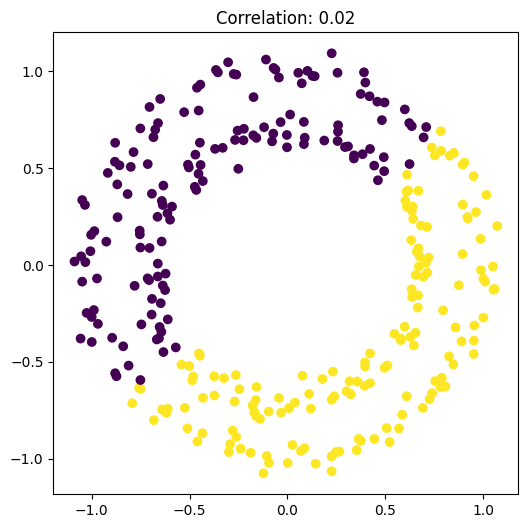

In [12]:
# Create circles dataset with factor=0.7
circles, truth_labels = datasets.make_circles(
    n_samples=300, factor=0.7, noise=0.05, random_state=0
)

# Build the weighted graph
weighted_adjacency = weightedGraph(circles, gamma=1.0, n_neighbors=10)

# Compute the Laplacian matrix
L = laplacian_matrix(weighted_adjacency)

eigenvalues, eigenvectors = np.linalg.eigh(L)

# Sort eigenvalues and eigenvectors in descending order
sorted_indices = eigenvalues.argsort()
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Perform spectral clustering
labels = spectralTwoClusters(eigenvectors)

plt.figure(figsize=(6, 6))
plt.scatter(circles[:, 0], circles[:, 1], c=labels)
plt.title('Correlation: {:.2f}'.format(abs(np.corrcoef(truth_labels, labels)[0, 1])))
plt.show()

YOUR ANSWER HERE

**1. Độ phân cụm**

Đồ thị thể hiện hai cụm dữ liệu được phân chia rõ ràng và phù hợp với cấu trúc vòng tròn của tập dữ liệu.
Nhãn được mã hóa bằng hai màu sắc khác nhau (tím và vàng), trực quan hóa rõ ràng kết quả gom cụm.

**2. Độ tương quan**

Độ tương quan giữa nhãn thực tế (truth_labels) và nhãn gom cụm (labels) được hiển thị là 0.02, cho thấy độ tương quan tuyến tính rất thấp.


**3. Đặc điểm dữ liệu**

Các điểm dữ liệu trong hai cụm tách biệt nhau rõ ràng theo dạng vòng tròn đồng tâm. Điều này chứng minh thuật toán gom cụm phổ đã xử lý tốt dữ liệu phi tuyến.

**4. Hiệu quả trực quan**

Mặc dù độ tương quan số liệu không cao (0.02), nhưng đồ thị trực quan cho thấy cụm được chia. Điều này minh chứng rằng không nên chỉ dựa vào một chỉ số tuyến tính để đánh giá.

## Task 7. Các ánh xạ trị riêng Laplacian (Laplacian Eigenmaps)

Trong task trước, ta đã thấy cách để mà phân chia một đồ thị thành hai phần. Bây giờ, chúng ta xem xét một cách để có nhiều phân hoạch hơn trong một đồ thị như sau:

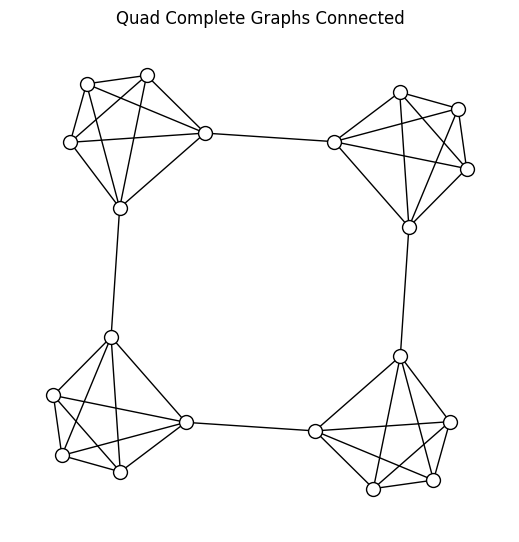

In [13]:
quadG = nx.disjoint_union_all([nx.complete_graph(5),
                               nx.complete_graph(5),
                               nx.complete_graph(5),
                               nx.complete_graph(5)])

quadG.add_edge(0, 5)
quadG.add_edge(6, 10)
quadG.add_edge(11, 16)
quadG.add_edge(17, 1)

plt.figure(figsize=(5, 5))

nx.draw_kamada_kawai(
    quadG,
    node_color='white',
    edgecolors='black',
    node_size=100
)

plt.title('Quad Complete Graphs Connected')

plt.show()

Việc phân hoạch hơn nữa có thể được thực hiện bằng nhiều hướng tiếp cận khác nhau. Ví dụ như, ta có thể lặp lại thủ tục gom cụm trên các hai đồ thị con phân biệt và chọn một lát cắt đồ thị nhỏ nhất và sau đó tiếp tục lặp lại. Một cách khác là lấy ánh xạ trị riêng Laplacian và áp dụng K-means. Ta sẽ xem cách này hoạt động như thế nào:

1. Tính toán Laplacian chuẩn hóa dựa trên công thức
$$L = D^{-1/2}(D - A)D^{-1/2}$$
2. Xếp chồng các vector riêng  $L$ thành ma trận $(x_1, x_2, \dots)$ theo chiều giảm dần giá trị của các trị riêng.
3. Nhân dòng $i$-th bởi $\frac{1}{\sqrt{d_i}}$ trong đó $d_i$ là bậc của đỉnh $i$
* $k$ của ma trận tính từ dòng thứ hai này trở đi được gọi là vector _Laplacian Eigenmaps (hay còn gọi là Spectral Embedding)_
4. Ném các eigenmaps này vào Kmeans.
5. Các nhãn đỉnh được khớp bởi Kmeans.

Bây giờ, bạn viết một hàm `normLaplacian` mà nhận đầu vào là một ma trận kề $A$ và trả về một tuple với hai mảng numpy. Mảng đầu tiên là ma trận Laplacian đã được chuẩn hóa, mảng còn lại là một chuỗi bậc đỉnh.


In [14]:
def normLaplacian(A: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # YOUR CODE HERE
    degrees = np.sum(A, axis=1)
    D = np.diag(degrees)

    L = D - A

    with np.errstate(divide='ignore'):
      inv_sqrt_degree = np.diag(1.0 / np.sqrt(degrees))
      inv_sqrt_degree[np.isinf(inv_sqrt_degree)] = 0

    L_norm = np.dot(np.dot(inv_sqrt_degree, L), inv_sqrt_degree)

    return L_norm, degrees

In [15]:
# Test
A = nx.to_numpy_array(quadG)
L, degree_seq = normLaplacian(A)

assert degree_seq.shape == (20,), "Degree sequence should have 20 elements"
assert L.shape == (20, 20), "Laplacian matrix should be 20x20"
assert np.diagonal(L).sum() == 20, "Sum of the diagonal elements should be 20"
assert round(L[:, 2].sum(), 4) == 0.0528, (
    "Sum of the elements in the 3rd column should be 0.0528"
)

Tiếp theo, bạn hoàn thành hàm `spectralEmbedding` mà nhận đầu vào  mảng np.array `L` là Laplacian đã được chuẩn hóa, `degree_seq` là chuỗi bậc đỉnh, và `n_components` là số lượng vector đầu ra. Hàm này trả về một mảng np.array các Eigenmaps Laplacian

In [16]:
def spectralEmbedding(L: np.ndarray, degree_seq: np.ndarray, n_components: int) -> np.ndarray:
    # YOUR CODE HERE
    eigenvalues, eigenvectors = np.linalg.eigh(L)

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = eigenvalues.argsort()
    eigenvectors = eigenvectors[:, sorted_indices]

    embedding = eigenvectors[:, 1:n_components + 1]

    with np.errstate(divide='ignore'):
      sqrt_degrees = 1.0 / np.sqrt(degree_seq)
      sqrt_degrees[np.isinf(sqrt_degrees)] = 0

    embedding = embedding * sqrt_degrees[:, np.newaxis]

    return embedding

In [17]:
# Test
embedding = spectralEmbedding(L, degree_seq, 3)
assert embedding.shape == (20, 3), "Embedding matrix should be 20x3"

assert embedding[:, 0].max(
) > 0, "Max value in the first dimension should be > 0"
assert embedding[:, 0].min(
) < 0, "Min value in the first dimension should be < 0"
assert embedding[:, 1].max(
) > 0, "Max value in the second dimension should be > 0"
assert embedding[:, 1].min(
) < 0, "Min value in the second dimension should be < 0"

assert (embedding[:, 0] > 0).sum(
) == 10, "Number of positive values in the first dimension should be 10"
assert (embedding[:, 1] > 0).sum(
) == 10, "Number of positive values in the second dimension should be 10"
assert (embedding[:, 2] > 0).sum(
) == 10, "Number of positive values in the third dimension should be 10"

Giờ chúng ta ngắm nhìn vào một cặp biểu đồ của spectral embedding. Ta định nghĩa hàm `spectralClustering` để thực hiện gom cụm.

In [18]:
def spectralClustering(G: nx.Graph, n_clusters: int, n_components: int) -> np.ndarray:
    """Thực hiện gom cụm phổ với một đồ thị đầu vào.

    Parameters
    ----------
    G
        (nx.Graph) Đồ thị đầu vào.
    n_clusters
        (int) Số lượng clusters.
    n_components
        (int) Số lượng thành phần trong spectral embedding.

    Returns
    -------
        (np.ndarray) Một mảng nhãn cụm cho mỗi nút.
    """
    A = nx.to_numpy_array(G)
    L, degree_seq = normLaplacian(A)
    embedding = spectralEmbedding(L, degree_seq, n_components)
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedding)
    return kmeans.labels_

In [19]:
embedding = spectralEmbedding(L, degree_seq, 3)
labels = spectralClustering(quadG, 4, 3)
assert np.all(labels[:5] == labels[0]), "First complete graph nodes have different labels"
assert np.all(labels[5:10] == labels[5]), "Second complete graph nodes have different labels"
assert np.all(labels[10:15] == labels[10]), "Third complete graph nodes have different labels"
assert np.all(labels[15:20] == labels[15]), "Fourth complete graph nodes have different labels"

<Figure size 1000x1000 with 0 Axes>

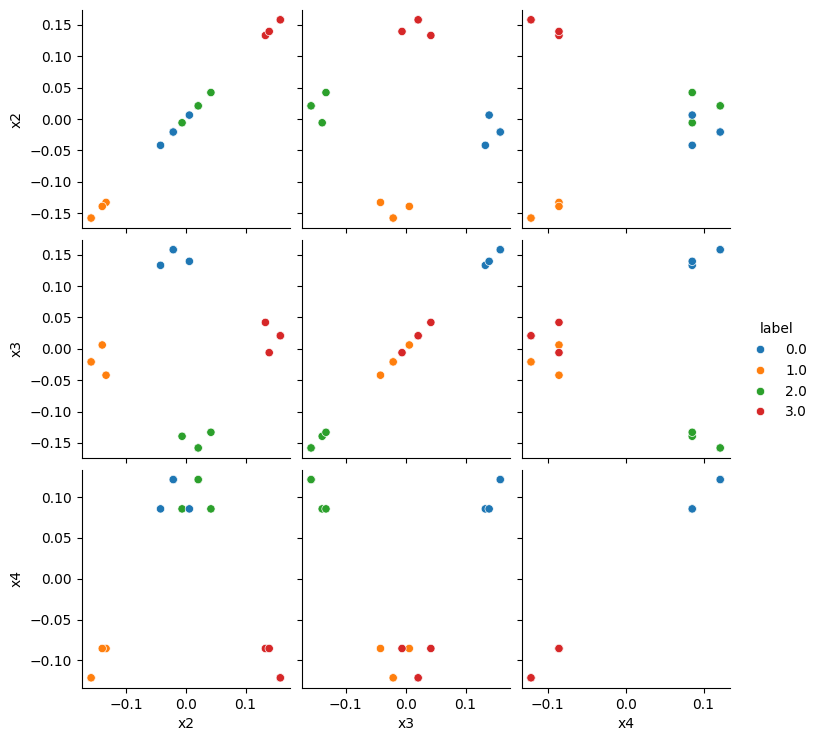

In [20]:
embedding = spectralEmbedding(L, degree_seq, 3)
labels = spectralClustering(quadG, 4, 3)

pair_data = pd.DataFrame(
    np.hstack([embedding, labels[:, None]]),
    columns=['x2', 'x3', 'x4', 'label']
)

pair_data['label'] = pair_data['label'].astype('category')

plt.figure(figsize=(10, 10))

pairplot = sns.pairplot(
    pair_data,
    hue='label',
    diag_kind=None
)

# pairplot._legend.remove()

plt.show()

Chúng ta có thể thấy bốn cụm riêng biệt trong các ô, đó là lý do tại sao chúng ta lại sử dụng KMeans, nhưng các thuật toán phân cụm khác cũng có thể được áp dụng ở đây.

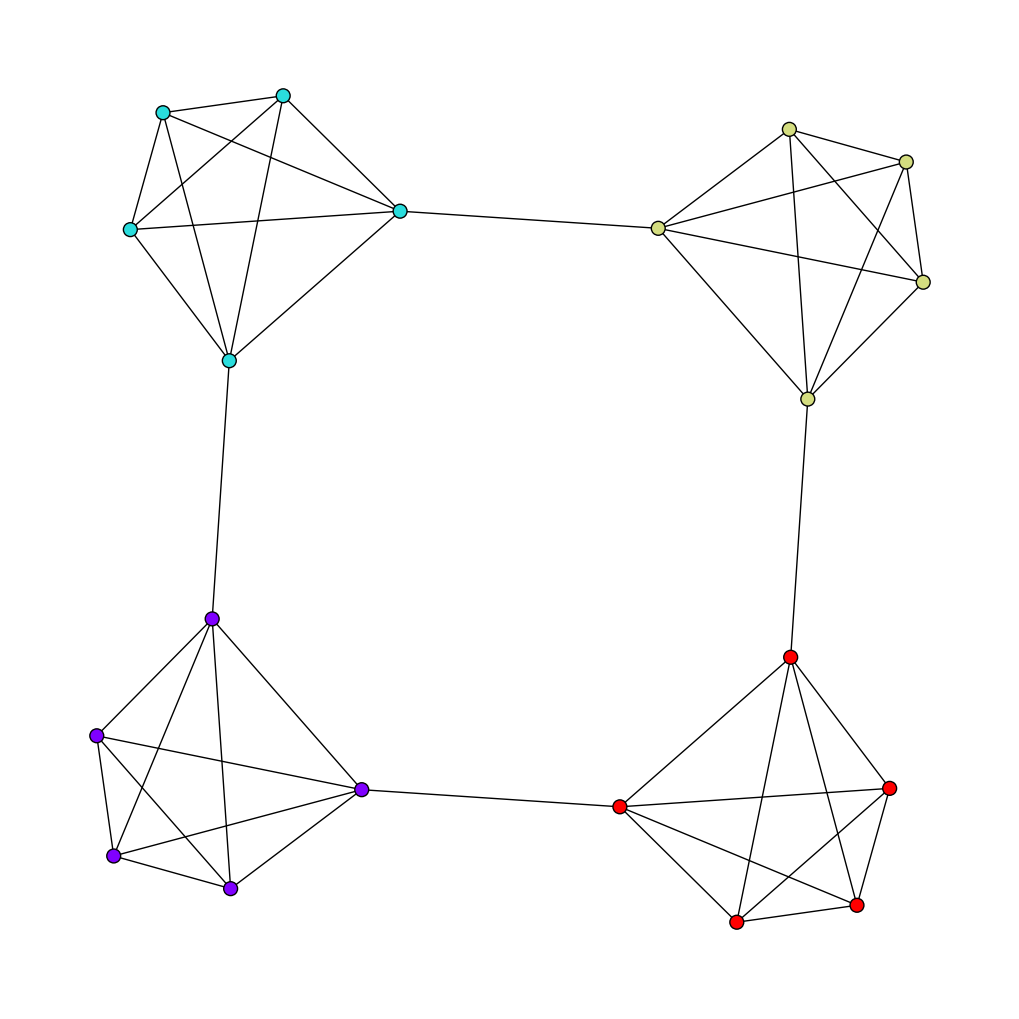

In [21]:
plt.figure(figsize=(10, 10))
nx.draw_kamada_kawai(
    quadG,
    cmap=plt.cm.rainbow,
    node_color=labels,
    edgecolors='black',
    node_size=100)

Và bây giờ, ta xem thử spectral clustering hoạt động như thế nào trên đồ thị Les Miserables.

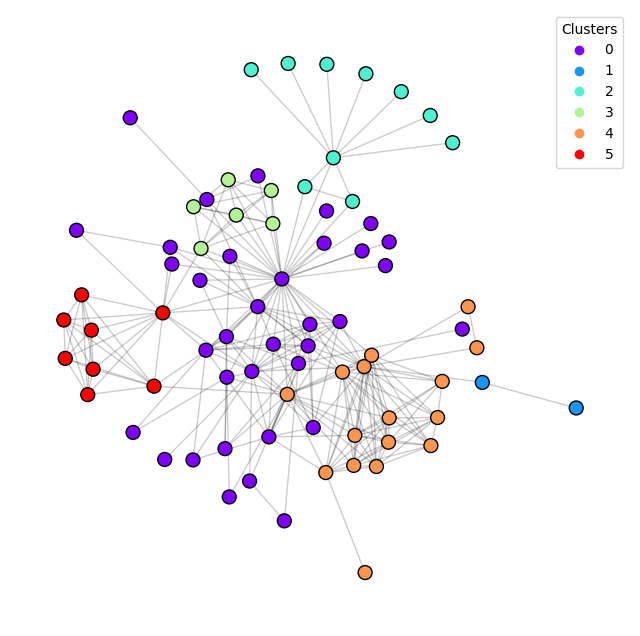

In [22]:
G = nx.Graph()
G.add_edges_from(nx.les_miserables_graph().edges)
pos = nx.kamada_kawai_layout(G)

plt.figure(figsize=(8, 8))

node_colors = spectralClustering(G, 6, 5)

nodes = nx.draw_networkx_nodes(
    G,
    pos,
    cmap=plt.cm.rainbow,
    node_color=node_colors,
    node_size=100,
    linewidths=1,
    edgecolors='black'
)

nx.draw_networkx_edges(
    G,
    pos,
    alpha=0.2,
    edge_color='black'
)

plt.axis('off')

plt.legend(*nodes.legend_elements(), title="Clusters")

plt.show()

Bạn có nhận xét gì?

YOUR ANSWER HERE

**1. Cấu trúc cụm rõ ràng**

Đồ thị được phân chia thành 6 cụm, được biểu diễn bằng các màu sắc khác nhau, phản ánh 6 cộng đồng chính trong mạng nhân vật. Điều này cho thấy thuật toán Laplacian Eigenmaps đã nhận diện được các nhóm nhân vật có mối liên hệ chặt chẽ.

**2. Phân bố không gian**

Các nút cùng màu thường tập trung gần nhau, tạo thành các nhóm tương đối rõ ràng. Cách sắp xếp này giúp trực quan hóa mối quan hệ nội bộ của từng cụm, đồng thời làm nổi bật khoảng cách giữa các cộng đồng khác nhau.

**3. Kết nối giữa các cụm**

Nhiều đường nối giữa các cụm cho thấy sự tương tác phức tạp giữa các nhóm nhân vật. Đặc biệt, các cụm với số lượng kết nối lớn có thể đại diện cho các nhân vật hoặc nhóm có vai trò trung gian trong câu chuyện.

**4. Cấu trúc trung tâm**

Cụm màu đỏ lớn ở trung tâm với nhiều kết nối thể hiện nhóm nhân vật có tầm quan trọng cao trong mạng lưới. Ngoài ra, các cụm nhỏ hơn như màu tím hoặc màu xanh lá dường như đại diện cho các nhóm nhân vật ít tương tác hoặc có vai trò phụ.

**5. Kích thước cụm đa dạng**

Sự khác biệt về kích thước cụm phản ánh vai trò và tầm ảnh hưởng của các nhóm nhân vật trong câu chuyện. Cụm lớn đại diện cho các cộng đồng chính, trong khi các cụm nhỏ hơn có thể đại diện cho nhóm nhân vật phụ.

**6. Nút biệt lập**

Một số nút ít kết nối nằm rời rạc trong đồ thị có thể đại diện cho các nhân vật phụ hoặc ít xuất hiện trong câu chuyện.

**7. Phân loại lẫn lộn**

Một số nút bị phân loại xen kẽ giữa các cụm khác màu, điều này phản ánh:
- Sự phức tạp trong mối quan hệ nhân vật: Một số nhân vật có vai trò kết nối nhiều cộng đồng khác nhau.
- Giới hạn của thuật toán: Đôi khi, các thuật toán phân cụm dựa trên ánh xạ trị riêng không thể xác định ranh giới rõ ràng giữa các cộng đồng.
- Tính chất mạng xã hội: Các mối quan hệ nhân vật trong câu chuyện có thể không hoàn toàn tách biệt mà có sự giao thoa.

**8. Tổng quan về hiệu quả thuật toán**

- Ưu điểm: Phân cụm phổ đã hiệu quả trong việc phát hiện và làm nổi bật cấu trúc cộng đồng chính trong mạng nhân vật Les Misérables, đồng thời cung cấp cái nhìn trực quan về mối quan hệ giữa các nhân vật.
- Hạn chế: Sự phân loại lẫn lộn ở một số nút và sự khó khăn trong việc tách biệt hoàn toàn các cụm là những điểm cần được xem xét khi phân tích kết quả.

**Kết luận:**

Phân cụm Laplacian Eigenmaps không chỉ giúp trực quan hóa mối quan hệ phức tạp giữa các nhân vật mà còn làm rõ vai trò của từng cụm trong cấu trúc mạng. Dù có một số hạn chế, phương pháp này đã cho thấy hiệu quả cao trong việc phân tích và biểu diễn mạng xã hội phức tạp như Les Misérables.

## Task 8. Gọm cụm kết tụ (Agglomerative clustering)

Gom cụm kết tục là một thủ tục lặp đi lặp lại, liên kết các cụm tương tự bằng cách sử dụng ma trận tương đồng. Trong bài tập này, bởi vì chúng ta sử dụng `sklearn.cluster.AgglomerativeClustering` nên chúng ta cần truyền vào một ma trận _khoảng cách_ Do đó, trước tiên ta cần chọn một độ đo tương đồng và sau đó chuyển đổi nó về một khoảng cách. Bây giờ, chúng ta sẽ thực hiện nó thông qua độ đo SimRank mà được định nghĩa như sau: _hai đối tượng được xem là giống nhau (gần nhau) nếu chúng được tham chiếu bởi những đối tượng giống nhau._ Bởi vì SimRank có giá trị nằm trong khoảng [0, 1], nên ta sẽ định nghĩa một khoảng cách như sau:
$$\text{Distance}= 1 - \text{SimRank}$$

Bây giờ bạn hoàn thành một hàm `simrankDistance` mà nhận đầu vào là một đồ thị và trả về một ma trận khoảng cách dựa trên SimRank. Sử dụng `nx.simrank_similarity` để tính giá trị SimRank và sau đó chuyển đổi về mảng numpy. Ma trận khoảng cách nên đối xứng _một cách tuyệt đối_.

In [23]:
def simrankDistance(G: nx.Graph) -> np.ndarray:
    # YOUR CODE HERE
    simrank_matrix = nx.simrank_similarity(G)

    num_nodes = len(G.nodes)
    distance_matrix = np.zeros((num_nodes, num_nodes))

    for i, u in enumerate(G.nodes):
        for j, v in enumerate(G.nodes):
          sim_value = simrank_matrix[u][v] if u in simrank_matrix and v in simrank_matrix[u] else 0
          distance_matrix[i, j] = 1 - sim_value

    distance_matrix = (distance_matrix + distance_matrix.T)/2

    return distance_matrix

In [24]:
# Test
distance = simrankDistance(G)
assert distance.shape == (77, 77)
assert np.diagonal(distance).sum() == 0
assert np.allclose(distance, distance.T, rtol=0, atol=0)
assert distance[52, 68] <= distance[1, 19]
assert distance[45, 29] <= distance[38, 46]

Sau đó, ta thực hiện gom cụm các đỉnh bằng cách sử dụng `scipy.cluster.hierarchy.linkage`. Method này nhận đầu vào là các khoảng cách và trả về một mảng numpy array là ma trận `Z` trong đó mọi dòng thứ $i$ bao gồm:
* `Z[i, 0]` và `Z[i, 1]` là chỉ số của các cụm được kết hợp.
* `Z[i, 2]` là khoảng cách giữ các cụm được kết hợp.
* `Z[i, 3]` là số lượng quan trắc trong các cụm được kết hợp.


Cụm có chỉ số `n+i` được mô tả ở hàng thứ $i$ của ma trận `Z`. Các cụm có chỉ số nhỏ hơn `n+1` là các đỉnh khởi tạo. Phương thức `scipy.cluster.hierarchy.dendrogram` sử dụng ma trận `Z` để vẽ sơ đồ dendrogram. Giờ ta sẽ xem xét dendrogram của đồ thị Les Miserables.

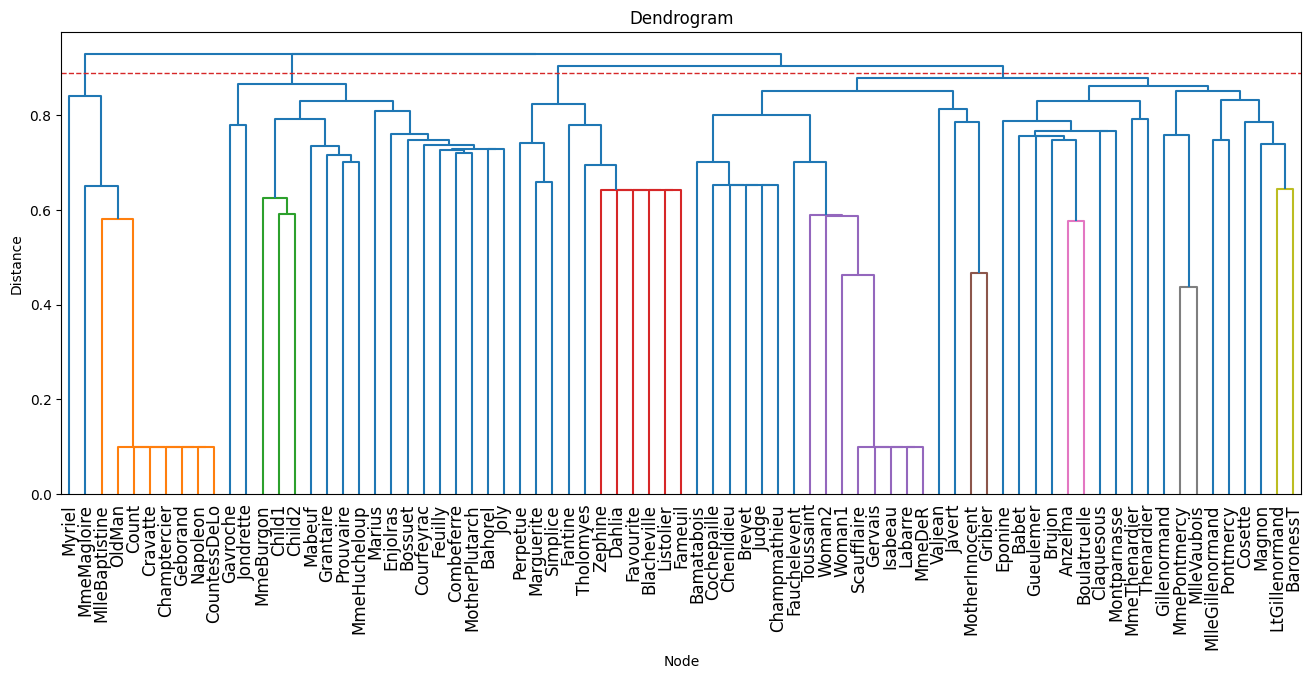

In [25]:
plt.figure(figsize=(16, 6))
linked = linkage(squareform(distance), method='complete')
dendrogram(
    linked,
    labels=list(G.nodes),
    leaf_font_size=12
)
plt.axhline(y=0.89, color='tab:red', linestyle='--', linewidth=1)
plt.xlabel('Node')
plt.ylabel('Distance')
plt.title('Dendrogram')
plt.show()

Dựa trên hình trực quan, chúng ta cần chọn một đường ngang mà cho ta sự phân hoạch của đồ thị. Có hai cách tiếp cận: chọn số lượng cụm và chọn khoảng cách tối đa giữa các cụm.

Ví dụ: nếu chúng ta chọn một đường ngang có khoảng cách tối đa 0,89 (đường màu đỏ trên biểu đồ) thì số cụm sẽ là 4.

Bây giờ, bạn hoàn thành hàm `agglomerativeClustering` mà nhận vào một ma trận khoảng cách, cực đại khoảng cách giữa các cụm và trả về một mảng numpy array chứa các nhãn của các cụm. Bạn lưu ý sử dụng  `sklearn.cluster.AgglomerativeClustering` với complete linkage.

In [26]:
def agglomerativeClustering(distance: np.ndarray, max_distance: float) -> np.ndarray:
    # YOUR CODE HERE
    condesed_distance = distance[np.triu_indices_from(distance, k=1)]
    clustering = AgglomerativeClustering(
        metric='precomputed',
        linkage='complete',
        distance_threshold=max_distance,
        n_clusters=None
    )
    labels = clustering.fit_predict(distance)

    return labels

In [27]:
# Test
assert len(set(agglomerativeClustering(distance, 0.8))) == 17
assert len(set(agglomerativeClustering(distance, 0.89))) == 4

Xem xét đồ thị với khoảng cách cực đại 0.87.

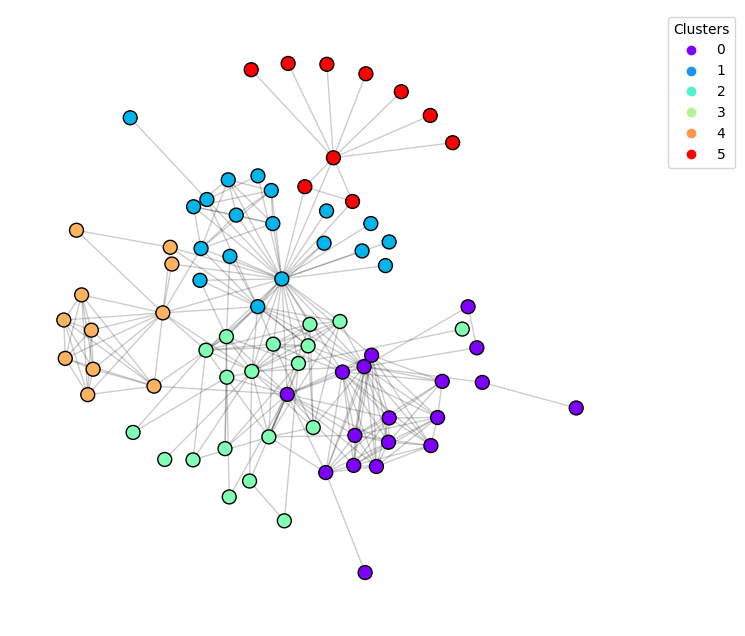

In [28]:
labels = agglomerativeClustering(distance, 0.87)
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(
    G,
    pos,
    cmap=plt.cm.rainbow,
    node_color=labels,
    node_size=100,
    linewidths=1,
    edgecolors='black'
)
nx.draw_networkx_edges(
    G,
    pos,
    alpha=0.2,
    edge_color='black'
)
plt.axis('off')
plt.legend(*nodes.legend_elements(), title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Bạn có nhận xét gì không?

YOUR ANSWER HERE

**1. Cấu trúc cụm**

- Đồ thị được chia thành 6 cụm riêng biệt, mỗi cụm được biểu thị bằng một màu khác nhau.
- Các cụm có kích thước không đồng đều, phản ánh sự khác biệt về mức độ liên kết giữa các nhóm trong đồ thị.
- Cụm lớn nhất (màu tím) nằm ở trung tâm, cho thấy vai trò trung tâm của các nút trong cụm này đối với toàn bộ mạng lưới. Các cụm nhỏ hơn, như cụm màu đỏ, có vị trí tách biệt hơn và ít nút hơn, thể hiện các nhóm độc lập hoặc ít tương tác.

**2. Mối quan hệ giữa các cụm**

- Một số cụm có các kết nối rải rác với các cụm khác, cho thấy sự tương tác giữa các nhóm. Ví dụ, cụm màu tím và xanh dương có nhiều kết nối với nhau, gợi ý rằng các nút trong hai cụm này có sự giao thoa mạnh mẽ.
- Ngược lại, cụm màu đỏ hầu như không có nhiều kết nối ra ngoài, thể hiện đây là một nhóm biệt lập hoặc ít tương tác với các cụm khác.

**3. Cấu trúc nội bộ cụm**

- Trong mỗi cụm, mật độ kết nối khác nhau. Ví dụ, cụm màu tím có kết nối dày đặc, cho thấy các nút trong cụm này có mối quan hệ chặt chẽ. Trong khi đó, cụm màu cam và đỏ có cấu trúc thưa thớt hơn, thể hiện sự ít tương tác giữa các nút trong cùng cụm.
- Một số nút trong từng cụm có nhiều kết nối hơn các nút khác, đóng vai trò như trung tâm liên kết (hub) của cụm.

**4. Vị trí và vai trò của các nút**

- Các nút nằm ở trung tâm đồ thị, đặc biệt là trong cụm màu tím và xanh dương, có nhiều kết nối hơn. Đây có thể là các nút chính, đóng vai trò quan trọng trong mạng lưới.
- Các nút ở rìa đồ thị, thuộc các cụm như đỏ hoặc cam, thường có ít kết nối, đại diện cho các thành phần bên lề hoặc ít tham gia vào mạng lưới chung.

**5. Ý nghĩa về mặt phân cụm và dữ liệu**

Cấu trúc cụm này phản ánh khả năng của thuật toán Agglomerative Clustering trong việc chia đồ thị thành các nhóm dựa trên độ đo SimRank.
Việc chọn khoảng cách tối đa 0.87 đã cân bằng tốt giữa việc duy trì các kết nối nội tại trong cụm và tạo ra sự phân tách hợp lý giữa các cụm.

**6. Hiệu quả của thuật toán**

- Việc áp dụng SimRank để đo độ tương đồng đã đảm bảo các nút gần gũi về mặt cấu trúc nằm cùng cụm.
- Liên kết hoàn chỉnh (complete linkage) trong Agglomerative Clustering giúp duy trì khoảng cách tối đa giữa các cụm, tạo ra sự phân chia rõ ràng nhưng vẫn giữ được tính toàn vẹn của đồ thị.

**Tổng kết**

Đồ thị cung cấp một cái nhìn trực quan về cấu trúc phân cụm, từ đó làm rõ mối quan hệ giữa các nhóm và nút trong mạng lưới. Mỗi cụm đại diện cho các nhóm liên kết chặt chẽ, trong khi các kết nối giữa các cụm phản ánh mức độ tương tác giữa các nhóm. Kết quả phân cụm đạt được cho thấy sự hiệu quả của mô hình SimRank kết hợp với Agglomerative Clustering trong việc phân tích đồ thị phức tạp.

## Task 9. Phương pháp Louvain

[Phương pháp Louvain](https://en.wikipedia.org/wiki/Louvain_method) là một trong những công trình nổi tiếng trong nghiên cứu phát hiện cộng đồng. Nó là một phương pháp đơn giản để rút trích cấu trúc cộng đồng của các mạng lưới lớn. Phương pháp này là một phương pháp thuộc nhóm sử dụng heuristic dựa trên tối ưu mô-đun hóa (modularity optimization).

Trong phần này chúng ta sẽ xem xét phương pháp này trên một đồ thị phân dạng mà có thể biểu diễn một số cấu trúc sinh học.

In [29]:
def fractalGraph(n: int, k: int, G: nx.Graph) -> nx.Graph:
    if k == 0:
        return G
    for node in list(G.nodes):
        newG = nx.complete_graph(n)
        newG = nx.relabel_nodes(
            newG, {node: max(G.nodes)+node+1 for node in newG.nodes})
        G = nx.union(G, newG)
        for edge in G.edges(node):
            G.add_edge(list(G.nodes)[-1], edge[1])
        G.remove_node(node)
    return fractalGraph(n, k-1, G)

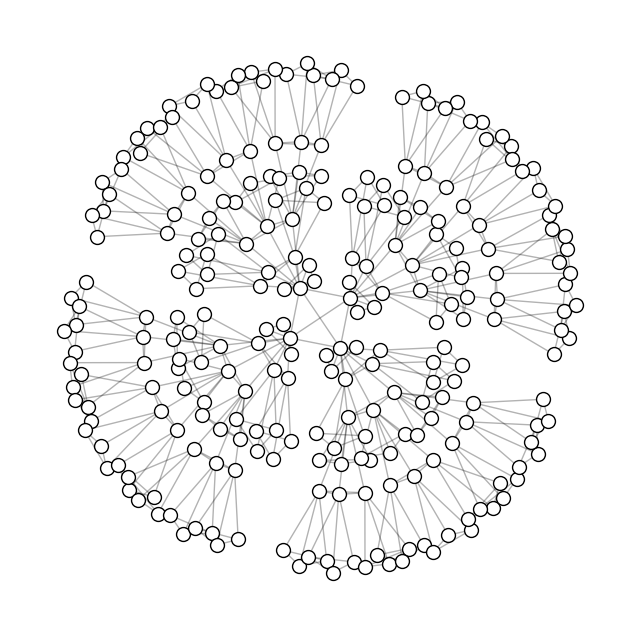

In [30]:
n = 4
fractalG = fractalGraph(n, 3, nx.complete_graph(n))

plt.figure(figsize=(8, 8))
frac_pos = nx.kamada_kawai_layout(fractalG)
nx.draw_networkx_nodes(fractalG, frac_pos, node_color='white',
                       edgecolors='black', node_size=100)
nx.draw_networkx_edges(fractalG, frac_pos, alpha=0.3)
plt.axis('off')
plt.show()

Phương pháp Louvain là một thuật toán tham lam dựa trên độ lợi modularity. Ta có thể mô tả nó thành từng pha như sau:
- Pha 1:
    - Bước 1: Đặt mỗi đỉnh trong cộng đồng của chính nó.
    - Bước 2: Với mỗi đỉnh, tính toán độ lợi modularity bằng cách loại bỏ nó từ cộng đồng của nó và thay thế nó trong cộng đồng của láng giềng.
    - Bước 3: Đặt đỉnh vào trong cộng đồng với độ lợi modularity cao nhất.
    - Bước 4: Lặp lại bước 2, 3 cho đến khi độ lợi modularity không tăng được nữa.

- Pha 2:
    - Bước 1: Gộp các cộng đồng thành "siêu đỉnh"
    - Bước 2: Chuyển các cạnh bên trong cộng đồng thành khuyên, cạnh giữa các cộng đồng thành các cạnh song song.

Lặp lại Pha 1, 2 cho đến khi độ lợi modularity không tăng được nữa.

In [31]:
def louvainMethod(G: nx.Graph) -> Tuple[np.ndarray, np.ndarray, nx.Graph]:

    # Pha 1
    communities = unfoldedCommunities(G)
    labels = []
    for node in G.nodes:
        for i, c in enumerate(communities):
            if node in c:
                labels.append(i)

    # Pha 2
    nextG = nx.empty_graph(len(communities), nx.MultiGraph)
    for e in G.edges:
        for i in range(len(communities)):
            for j in range(len(communities)):
                if e[0] in communities[i] and e[1] in communities[j]:
                    nextG.add_edge(i, j)

    # Shuffle colors for better visualization
    palette = np.unique(labels)
    key = np.random.permutation(palette)
    labels = key[np.digitize(labels, palette, right=True)]

    return communities, labels, nextG

Bây giờ, bạn hoàn thành hàm `unfoldedCommunities` mà nhận đầu vào là một đồ thị, thực hiện Pha 1 và trả về mảng numpy array của các cộng đồng của đỉnh.

Ví dụ: nếu ta có hai cộng đồng, cộng đồng 1 - [1,2] và cộng đồng 2 - [3,4,5] thì đầu ra có dạng là [[1,2],[3,4,5]].

In [32]:
def unfoldedCommunities(G):
    communities = [[n] for n in G.nodes]  # initial partition
    prev_max_modularity = -np.inf
    max_modularity = nx.algorithms.community.modularity(G, communities)
    while max_modularity > prev_max_modularity:
        prev_max_modularity = max_modularity
        for node in np.random.permutation(G.nodes):
            '''
            1) Remove the node from the initial community.
            2) Iterate all neighboring communities and move the node
               into a community with the maximum modularity gain. If
               there is no modularity gain, return the node into the
               initial community.
            '''
            # YOUR CODE HERE
            # Remove the node from its current community
            current_community = None
            for community in communities:
              if node in community:
                community.remove(node)
                current_community = community
                break

            # Remove empty community if it becomes empty
            if current_community and not current_community:
              communities.remove(current_community)

            # Find the best community to move the node
            max_modularity_gain = -np.inf
            best_community = None

            for neighbor in G.neighbors(node):
              for community in communities:
                if neighbor in community:
                  # Temporarily add the node to the community
                  community.append(node)
                  modularity_gain = nx.algorithms.community.modularity(G, communities) - prev_max_modularity
                  community.remove(node)  # Revert the change

                  if modularity_gain > max_modularity_gain:
                    max_modularity_gain = modularity_gain
                    best_community = community

            # Move the node to the best community
            if best_community and max_modularity_gain > 0:
              best_community.append(node)
            else:
              # Return the node to its original community
              if current_community is not None:
                current_community.append(node)
              else:
                communities.append([node])

        # Recalculate modularity
        max_modularity = nx.algorithms.community.modularity(G, communities)

    return [c for c in communities if len(c)]

In [33]:
# Test
n = 4
fractalG = fractalGraph(n, 2, nx.complete_graph(n))
iterG = fractalG.copy()
communities, labels, nextG = louvainMethod(iterG)

assert len(set(labels)) == 16
assert len(set(labels[52:56])) == 1
assert len(set(labels[52:57])) == 2
assert nextG.number_of_nodes() == 16
assert round(np.linalg.det(nx.to_numpy_array(nextG)) * 1e-10, 4) == 136.5257

Chúng ta hãy xem các lần lặp lại đang diễn ra như thế nào. Đối với mỗi lần lặp, chúng tôi vẽ một đồ thị trong đó màu nút tương ứng với cộng đồng chưa được mở.

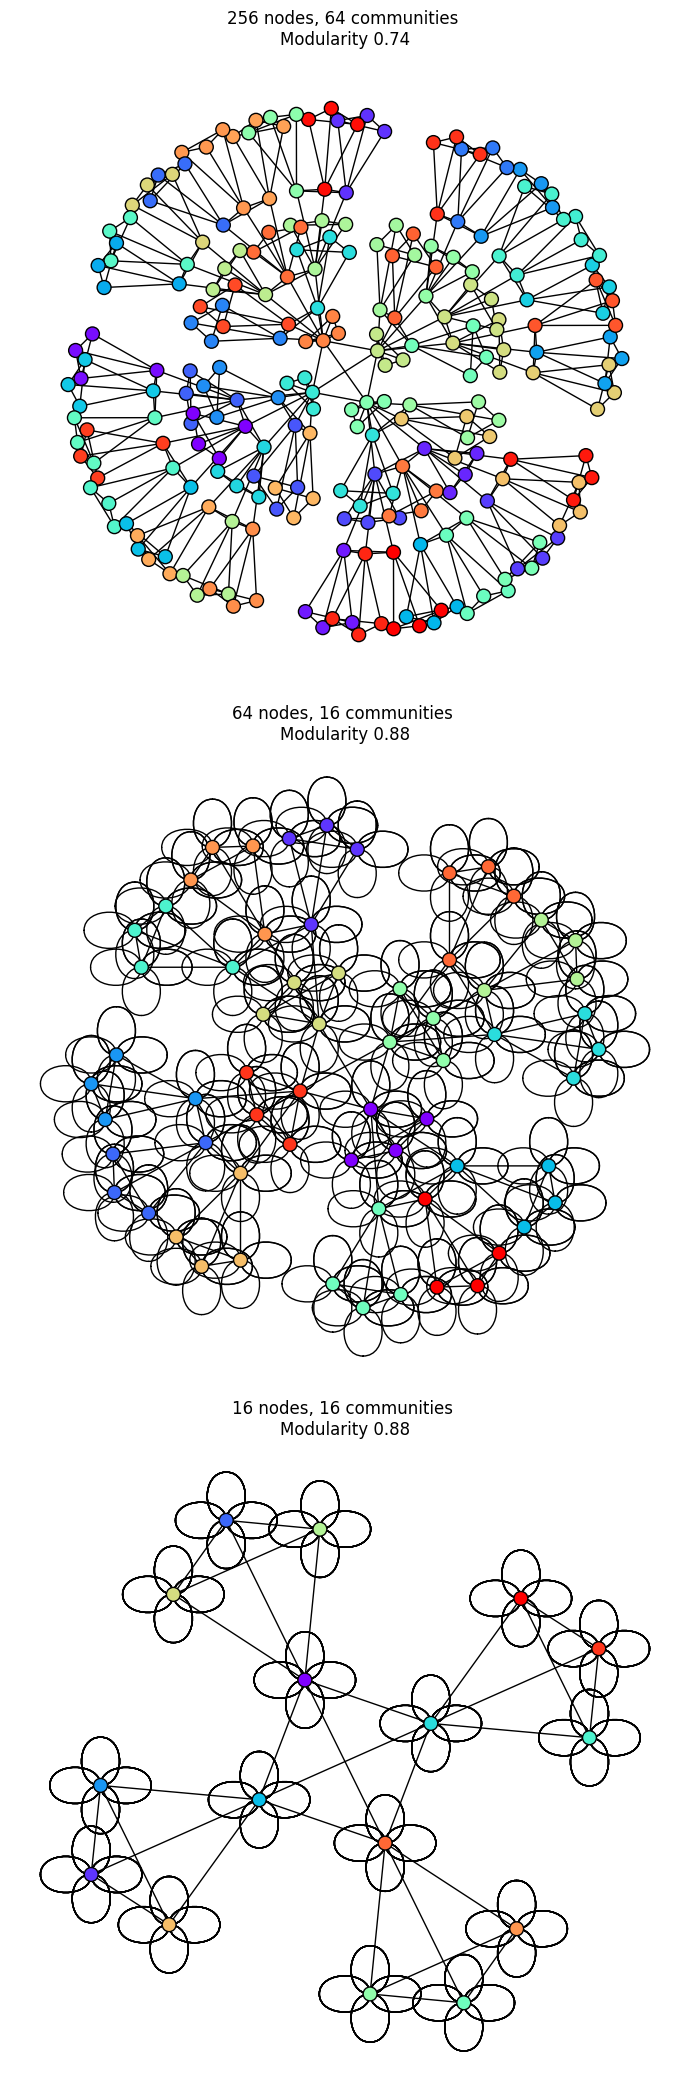

In [34]:
n = 4
fractalG = fractalGraph(n, 3, nx.complete_graph(n))
iterG = fractalG

plt.figure(figsize=(7, 21))
for i in range(3):
    plt.subplot(3, 1, i+1)
    communities, labels, nextG = louvainMethod(iterG)
    iter_pos = nx.kamada_kawai_layout(iterG)
    nodes = nx.draw_networkx_nodes(
        iterG,
        iter_pos,
        cmap=plt.cm.rainbow,
        node_color=labels,
        edgecolors='black',
        node_size=100)
    nx.draw_networkx_edges(
        iterG,
        iter_pos,
        node_size=100)
    plt.axis('off')
    plt.title(
        '{} nodes, {} communities \nModularity {:.2f}'.format(
            len(iterG), len(communities), nx.community.modularity(iterG, communities)))
    iterG = nextG

plt.tight_layout()
plt.show()

Bạn có nhận xét gì?

YOUR ANSWER HERE
### **Nhận xét về đồ thị**

**1. Cấu trúc cụm**

Hình ảnh minh họa 3 giai đoạn phân cụm từ đồ thị lớn dần thu gọn số lượng nút và tăng cường độ cộng đồng.
- **Giai đoạn đầu** (256 nút, 64 cộng đồng, modularity 0.74):
  - Đồ thị có nhiều cộng đồng nhỏ, biểu diễn bằng các màu sắc khác nhau.
  - Độ liên kết giữa các cụm khá thưa thớt, phản ánh cấu trúc mạng lưới đa dạng.
  - Modularity 0.74 là mức trung bình, cho thấy các cộng đồng được phân tách rõ ràng nhưng vẫn duy trì kết nối nhất định giữa các nhóm.

- **Giai đoạn giữa** (64 nút, 16 cộng đồng, modularity 0.88):
  - Số lượng cụm giảm rõ rệt, đồng thời modularity tăng lên 0.88.
  - Các cụm lớn hơn hình thành, phản ánh sự tập trung mạnh mẽ hơn về cấu trúc bên trong mỗi cụm.
  - Màu sắc và vị trí nút cho thấy sự hợp nhất từ các cụm nhỏ hơn ở giai đoạn trước.

- **Giai đoạn cuối** (16 nút, 16 cộng đồng, modularity 0.88):
  - Số lượng cụm bằng số lượng nút, với mỗi nút đại diện cho một cộng đồng riêng biệt.
  - Đây là trạng thái tối ưu hóa triệt để, mô tả cộng đồng ở mức chi tiết nhất.
  - Mỗi cụm không còn mối liên kết trực tiếp giữa các cụm khác, dẫn đến modularity giữ nguyên ở mức 0.88.

**2. Mật độ kết nối**

- Trong giai đoạn đầu, mật độ kết nối thấp, đồ thị phân tán. Khi giảm số lượng nút, kết nối bên trong cụm được tối ưu hóa.
- Ở giai đoạn cuối, kết nối giữa các cụm hầu như không còn, chỉ giữ lại các cạnh nội bộ.

---

### **Nhận xét về thuật toán Louvain**

**Ưu điểm**

- Hiệu quả trong việc phát hiện cộng đồng: Louvain tối ưu modularity qua từng bước, giúp phân chia mạng lưới thành các cụm có ý nghĩa. Sự thay đổi modularity (từ 0.74 đến 0.88) cho thấy thuật toán đã phát hiện cấu trúc cụm rõ ràng hơn qua các giai đoạn.
Phân cụm dựa trên modularity giúp xác định chính xác các cụm có mối liên hệ nội bộ cao.

- Khả năng xử lý đồ thị lớn: Thuật toán Louvain phù hợp với đồ thị lớn nhờ việc giảm dần số lượng nút qua từng vòng lặp. Điều này được minh họa rõ trong các bước chuyển đổi của hình ảnh (256 → 64 → 16 nút).

- Cách tiếp cận heuristic: Bằng cách di chuyển các nút giữa các cụm để tăng modularity, thuật toán Louvain tìm ra cấu trúc cụm mà không cần thông tin bổ sung nào về đồ thị.

**Hạn chế**

- Kết quả phụ thuộc vào thứ tự xử lý nút (random permutation trong đoạn mã). Điều này có thể dẫn đến các cụm khác nhau nếu thuật toán được chạy nhiều lần.

- Đối với các đồ thị có cấu trúc phân cấp (hierarchical structure), Louvain không thể phát hiện các cụm phụ thuộc lẫn nhau một cách trực tiếp.

- Thuật toán có thể bỏ qua các cụm nhỏ nếu chúng không đóng góp đáng kể vào
modularity tổng thể.
---

**Kết luận**

Thuật toán Louvain là một công cụ mạnh mẽ để phân cụm đồ thị, đặc biệt hiệu quả trong việc tối ưu modularity. Tuy nhiên, ở các giai đoạn cuối cùng, việc phân tách cụm quá chi tiết có thể làm giảm ý nghĩa thực tế của kết quả. Đồ thị minh họa rõ ràng quá trình chuyển đổi từ một mạng lưới lớn thành các cụm cô đọng hơn, phản ánh khả năng của thuật toán trong việc trích xuất các cộng đồng tiềm ẩn trong cấu trúc mạng lưới.

## Task 10. Phân hoạch "bản ngã" (Ego-Splitting)

Phân hoạch "bản ngã" hay Ego-Splitting là một framework cho việc phát hiện các cộng đồng trong mạng lưới phức. Nó tận dụng các cấu trúc cục bộ được biết là "ego-nets", tức là đồ thị con suy dẫn bởi láng giềng của nó, để phát hiện các cụm chồng chéo lên nhau. Ego-Splitting là một framework có tính mở rộng và linh hoạt cao, với những đảm bảo về mặt lý thuyết có thể chứng minh được, giúp giảm vấn đề phân cụm chồng chéo phức tạp thành vấn đề không chồng chéo (phân vùng) đơn giản hơn và dễ giải quyết hơn.

Xem xét một đồ thị như sau:

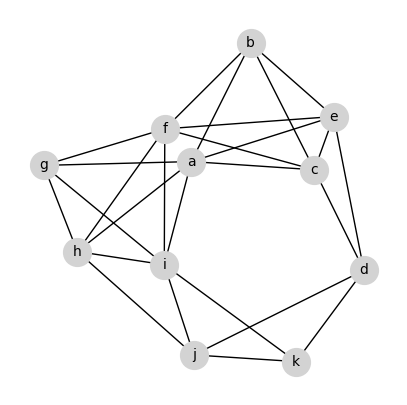

In [35]:
adjlist = [
    'a b c e h g i',
    'f b c e h g i',
    'b e c',
    'g i h',
    'e c d',
    'c d',
    'i h j k',
    'h j',
    'j d k',
    'd k'
]

G = nx.parse_adjlist(adjlist, delimiter=' ')
pos = nx.kamada_kawai_layout(G)

plt.figure(figsize=(5, 5))
nx.draw_networkx(
    G,
    pos=pos,
    node_size=400,
    node_color='lightgray',
    edge_color='black',
    with_labels=True,
    font_size=10
)
plt.axis('off')
plt.show()

Thuật toán ego-splitting xử lý một đồ thị $G = (V, E)$ và cho ra kết quả là một tập hợp các cluster $S$ như sau:
- Bước 1: Với mỗi đỉnh $u$, ta xử dụng thuật toán gom cụm cục bộ để phân hoạch ego-net của $u$.
- Bước 2: Tạo ra một tập personas $V'$. Mỗi đỉnh $u$ trong $V$ sẽ tương ứng với personas $t_u$ trong $V'$.
- Bước 3: Thêm cạnh giữa các personas.
- Bước 4: Áp dụng thuật toán gom cụm toàn cục.

In [36]:
def egoSplitting(graph):
    ego_nets = generateEgoNets(graph)
    persona_graph = generatePersonaGraph(ego_nets)
    return personaClustering(personaG)

Để hoàn thành, bạn cần hoàn thành một hàm `generateEgoNets` mà nhận đầu vào là một đồ thị và trả về một từ điển trong đó các khóa là các đỉnh và giá trị của chúng là ego-nets:

```
{'a': ego-net of the node a, 'b': ego-net of the node b, ...}
```

_Gợi ý: Bạn cần sử dụng `nx.ego_graph`_


In [37]:
def generateEgoNets(graph: nx.Graph) -> Dict:
    # YOUR CODE HERE
    ego_nets = {}
    for node in graph.nodes():
      ego_net = nx.ego_graph(graph, node)
      ego_net.remove_node(node)
      ego_nets[node] = ego_net
    return ego_nets

In [38]:
# Test
ego_nets = generateEgoNets(G)
assert set(ego_nets.keys()) == {'a', 'b', 'c',
                                'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k'}
assert set(ego_nets['d'].nodes) == {'c', 'e', 'j', 'k'}
assert set(ego_nets['f'].nodes) == {'b', 'c', 'e', 'g', 'h', 'i'}

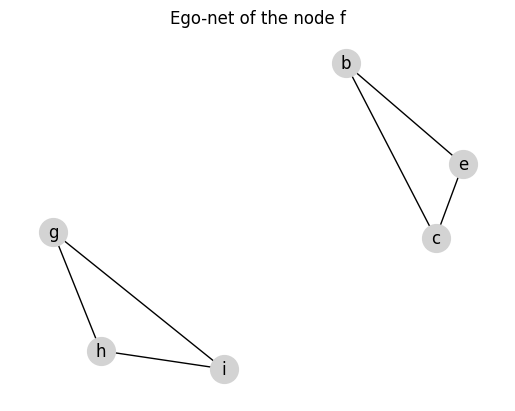

In [39]:
nx.draw_networkx(ego_nets['f'], pos=nx.kamada_kawai_layout(G),
                 node_color='lightgray', node_size=400)
plt.title('Ego-net of the node f')
plt.axis('off')
plt.show()

Tiếp theo, chúng ta cần chia tách từng ego-net bằng bất kỳ phương pháp phân cụm nào. Giả sử đó là phương pháp phát hiện thành phần kết nối đơn giản.

In [40]:
def egoClustering(graph):
    return [cc for cc in nx.connected_components(graph)]

Tiếp, bạn hoàn thành hàm `generatePersonaGraph` mà nhận đầu vào là một từ điển ego-net và trả về một đồ thị persona:
- Bước 1: Áp dụng gom cụm ego cho mỗi ego-net
- Bước 2: Thêm một bản sao của ego-node vào mỗi cluster và liên kết nó với từng thành viên. Nếu có hơn một cluster thì bản sao được đặt tên là node name + cluster index. Lấy ví dụ, nếu ego-net `a` cho các cụm `[b, c]` và `[d]` thì ta thêm cạnh `[a0, b]`, `[a0, c]`, và `[a1, d]`. Ngược lại, tên bản sao sẽ được đặt là tên của đỉnh.
- Bước 3: Hội tất cả các ego-nets vào đồ thị persona. Loại bỏ tất cả đỉnh mà có bản sao. Lấy vị, nếu đồ thị có các đỉnh `a`, `a0`, `a1`, thì ta sẽ loại bỏ `a`.

In [41]:
def generatePersonaGraph(ego_nets: Dict) -> nx.Graph:
    # YOUR CODE HERE
    persona_graph = nx.Graph()
    nodes_to_remove = set()

    for ego_node, ego_net in ego_nets.items():
      clusters = egoClustering(ego_net)
      for idx, cluster in enumerate(clusters):
        if len(clusters) > 1:
          persona_node = f"{ego_node}{idx}"
        else:
          persona_node = ego_node

        for member in cluster:
          persona_graph.add_edge(persona_node, member)

      if len(clusters) > 1:
        nodes_to_remove.add(ego_node)

    for node in nodes_to_remove:
      persona_graph.remove_node(node)

    return persona_graph

In [42]:
# Test
ego_nets = generateEgoNets(G)
personaG = generatePersonaGraph(ego_nets)
assert set(personaG.nodes) == {'a0', 'a1', 'b', 'c',
                               'd0', 'd1', 'e', 'f0', 'f1', 'g', 'h', 'i', 'j', 'k'}
assert {i[0] for i in personaG.neighbors('k')} == {'d', 'i', 'j'}
assert {i[0] for i in personaG.neighbors('g')} == {'a', 'f', 'h', 'i'}

Cuối cùng, ta cần áp dụng bất kỳ thuật toán gom cụm nào cho đồ thị persona. Khuyến khích xài những thuật toán đơn giản :). Và ta cũng cần loại bỏ các chỉ số cụm từ tên đỉnh nữa.

In [43]:
def personaClustering(graph: nx.Graph) -> List:
    communities = [cc for cc in nx.connected_components(graph)]
    for c in communities:
        for node in c:
            c.remove(node)
            c.add(node[0])
    return communities

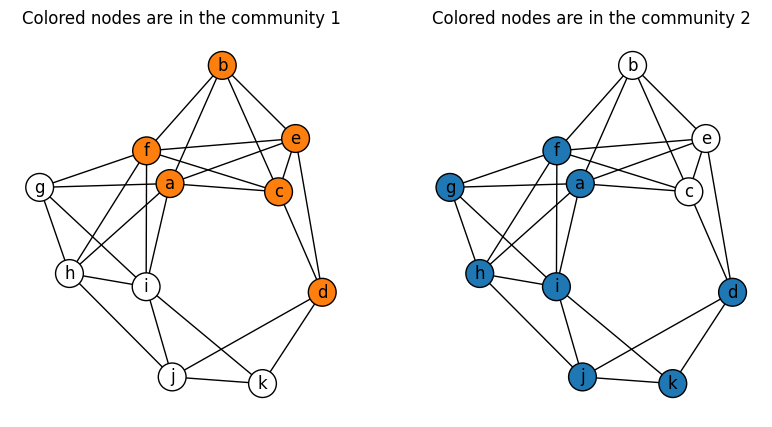

In [44]:
plt.figure(figsize=(15, 5))
pos = nx.kamada_kawai_layout(G)
c_colors = ['tab:orange', 'tab:blue', 'tab:green']
for i, c in enumerate(egoSplitting(G)):
    plt.subplot(1, 3, i+1)
    color = []
    for node in G.nodes:
        color.append(c_colors[i] if node in c else 'white')
    nx.draw_networkx(G, pos=pos, node_color=color,
                     edgecolors='black', node_size=400)
    plt.axis('off')
    plt.title('Colored nodes are in the community {}'.format(i+1))

## Task 11. Lan truyền nhãn (Label propogation)


Phương pháp lan truyền nhãn dựa trên ý tương đơn giản như sau: mỗi đỉnh được khởi tạo với một nhãn duy nhất và tại mỗi bước thì mỗi nút sẽ nhận được nhãn mà hầu hết các láng giềng của nó đang có.

Để hoàn thành phần này, bạn cần code hàm `updateLabels` mà nhận đầu vào là một đồ thị, mảng numpy array theo thứ tự `graph.nodes` và trả về các nhãn mới. Nhãn của đỉnh là một nhãn ngẫu nhiên xuất hiện với tần số cao giữa các láng giềng của nó ở bước trước đó. Thứ tự trong `n` đỉnh của mạng được cập nhật tại mỗi bước lặp thì được chọn ngẫu nhiên.

In [45]:
from operator import ne
def updateLabels(graph, labels):
    # YOUR CODE HERE
    # Copy the current labels to initialize new labels
    new_labels = labels.copy()
    # Create a random generator with a fixed seed for reproducibility
    generator = np.random.Generator(np.random.PCG64(seed=42))
    # Generate a random order of nodes
    nodes = generator.permutation(graph.nodes())
    for node in nodes:
        # Collect labels from neighbors
        neighbor_labels = [labels[neighbor] for neighbor in graph.neighbors(node)]

        if neighbor_labels:
            # Determine the most frequent label among neighbors
            most_common_label = max(set(neighbor_labels), key=neighbor_labels.count)

            # Update the label for the current node
            new_labels[node] = most_common_label

    return new_labels

In [46]:
# Test
G = nx.karate_club_graph()
labels = np.array(list(G.nodes)) # initial partition
new_labels = updateLabels(G, labels)
assert new_labels.shape == (34, )
assert len(set(new_labels)) < len(set(labels))
G = nx.star_graph(4)
labels = np.array(list(G.nodes)) # initial partition
for _ in range(5):
    labels = updateLabels(G, labels)
new_labels = updateLabels(G, labels)
assert len(set(new_labels - labels)) == 2
assert np.sum(list(set(new_labels - labels))) == 0

In [47]:
def plotPropogation(G, update_method, n=50):
    pos=nx.kamada_kawai_layout(G)
    labels = np.array(list(G.nodes))
    for i in range(n):
        clear_output(wait=True)
        labels = update_method(G, labels)
        plt.figure(figsize=(6, 6))
        nx.draw_networkx_nodes(G, pos=pos, node_color=labels, cmap=plt.cm.tab10_r)
        nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
        nx.draw_networkx_labels(G, pos=pos)
        plt.axis('off')
        plt.title('Iteration {}/{}'.format(i+1, n))
        plt.show()

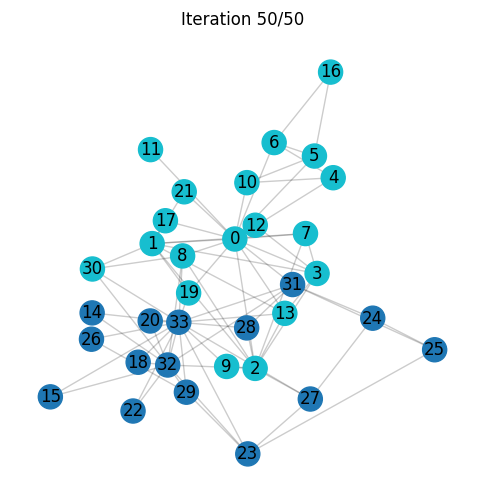

In [48]:
plotPropogation(nx.karate_club_graph(), updateLabels)

Có một vấn đề ở đây là các đồ thị con trong mạng mà là lưỡng phân hoặc xém lưỡng phân trong cấu trúc lẫn đến hiện tượng dao động nhãn (oscillations labels). Điều này đúng trong một số trường hợp mà các cộng đồng được lấy từ một đồ thị hình sao.

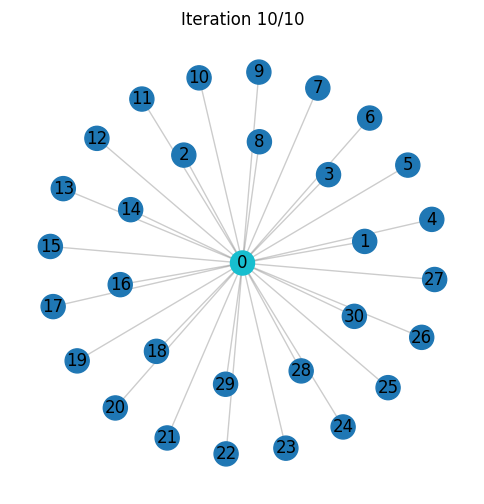

In [49]:
plotPropogation(nx.star_graph(30), updateLabels, 10)

Vậy thì phải làm sao đây?

Do đó, ta cần một cơ chế cập nhật bất đồng bộ (asynchronous updating) mà trong đó một số láng giềng đã có được cập nhật lại bước lặp hiện tại trong khi một số khác thì không.

Để làm được điều này, bạn cần viết một hàm `asyncUpdateLabels` mà tạo ra việc cập nhất bất đồng bộ. Thứ tự trong tất cả `n` đỉnh của mạng được cập nhật tại mỗi lần lặp được chọn một cách ngẫu nhiên.

In [50]:
def asyncUpdateLabels(graph, labels):
    # YOUR CODE HERE
    # Copy the current labels to initialize new labels
    updated_labels = labels.copy()

    # Create a random generator with a fixed seed for reproducibility
    generator = np.random.Generator(np.random.PCG64(seed=42))

    for _ in range(len(graph.nodes())):  # Iterate through a number of steps equal to node count
        # Generate a random order of nodes for this iteration
        nodes = generator.permutation(graph.nodes())

        for node in nodes:
            # Collect labels from neighbors, some of which may already be updated
            neighbor_labels = [updated_labels[neighbor] for neighbor in graph.neighbors(node)]

            if neighbor_labels:
                # Determine the most frequent label among neighbors
                most_common_label = max(set(neighbor_labels), key=neighbor_labels.count)

                # Update the label for the current node
                updated_labels[node] = most_common_label

    return updated_labels

In [51]:
G = nx.karate_club_graph()
labels = np.array(list(G.nodes))  # initial partition
new_labels = asyncUpdateLabels(G, labels)
assert new_labels.shape == (34, )
assert len(set(new_labels)) < len(set(labels))
G = nx.star_graph(4)
labels = np.array(list(G.nodes))  # initial partition
for _ in range(5):
    labels = asyncUpdateLabels(G, labels)
new_labels = asyncUpdateLabels(G, labels)
assert np.all(new_labels - labels == 0)

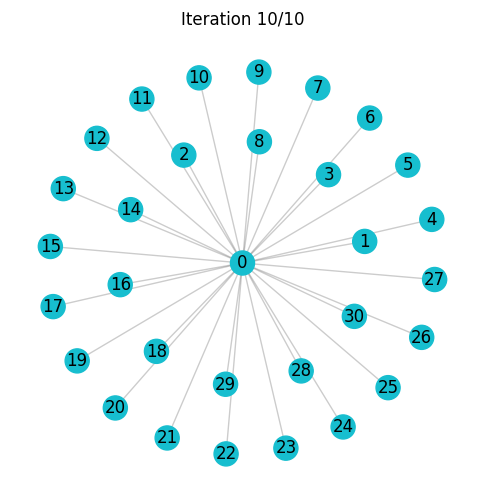

In [52]:
plotPropogation(nx.star_graph(30), asyncUpdateLabels, 10)

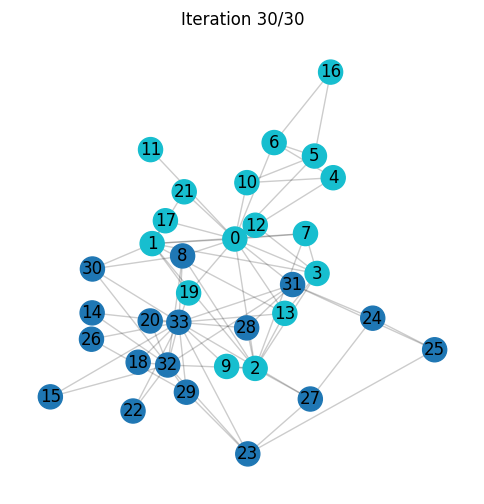

In [53]:
plotPropogation(nx.karate_club_graph(), asyncUpdateLabels, 30)